# Alphalens Analysis

This notebook uses pyfolio to create tearsheets for ourt three linear models

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

In [3]:
idx = pd.IndexSlice

## Load Data

In [4]:
with pd.HDFStore('data.h5') as store:
    lr_predictions = store['lr/predictions']
    lasso_predictions = store['lasso/predictions']
    lasso_scores = store['lasso/scores']
    ridge_predictions = store['ridge/predictions']
    ridge_scores = store['ridge/scores']

In [5]:
DATA_STORE = '../Data_Processing/Data/H5/assets.h5'

In [6]:
def get_trade_prices(tickers, start, stop):
    prices = (pd.read_hdf(DATA_STORE, 'Alt_Energy/prices').swaplevel().sort_index())
    #prices.index.names = ['Ticker', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'Open']
    return (prices
            .unstack('Ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [7]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

In [8]:
def get_factor(predictions):
    return (predictions.unstack('Ticker')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())    

## Linear Regression

In [9]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.head()

date                       Ticker
2020-02-21 00:00:00+00:00  BE        0.017181
                           BWEN      0.018020
                           CSIQ      0.012402
                           DOGEF     0.011498
                           ENPH      0.018515
dtype: float64

In [10]:
tickers = lr_factor.index.get_level_values('Ticker').unique()

In [11]:
trade_prices = get_trade_prices(tickers, 2019, 2021)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2019-01-07 00:00:00+00:00 to 2021-01-05 00:00:00+00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BE      503 non-null    float64
 1   BWEN    503 non-null    float64
 2   CSIQ    503 non-null    float64
 3   DOGEF   503 non-null    float64
 4   ENPH    503 non-null    float64
 5   FSLR    503 non-null    float64
 6   NEE     503 non-null    float64
 7   RUN     503 non-null    float64
 8   SEDG    503 non-null    float64
 9   SIEGY   503 non-null    float64
 10  VWSYF   503 non-null    float64
dtypes: float64(11)
memory usage: 47.2 KB


In [12]:
lr_factor_data = get_clean_factor_and_forward_returns(factor = lr_factor,
                                                      prices = trade_prices,
                                                      quantiles = 5,
                                                      periods = (1, 5, 10, 21))
lr_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200 entries, (Timestamp('2020-02-21 00:00:00+0000', tz='UTC'), 'BE') to (Timestamp('2020-12-03 00:00:00+0000', tz='UTC'), 'VWSYF')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               2200 non-null   float64
 1   5D               2200 non-null   float64
 2   10D              2200 non-null   float64
 3   21D              2200 non-null   float64
 4   factor           2200 non-null   float64
 5   factor_quantile  2200 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 111.3+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.141256,0.042350,-0.012965,0.024666,600,27.272727
2,-0.092097,0.046072,-0.005406,0.020304,400,18.181818
3,-0.068577,0.050938,-0.001232,0.018930,400,18.181818
4,-0.055065,0.055211,0.002915,0.018201,400,18.181818
5,-0.048777,0.072760,0.009654,0.017921,400,18.181818


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.754,0.308,0.111,0.255
beta,-0.092,-0.053,-0.109,-0.080
Mean Period Wise Return Top Quantile (bps),37.785,12.753,5.107,3.062
Mean Period Wise Return Bottom Quantile (bps),-3.521,-10.397,0.617,-9.941
Mean Period Wise Spread (bps),41.307,22.439,3.559,11.902


Information Analysis


,1D,5D,10D,21D
IC Mean,0.027,0.043,0.016,0.056
IC Std.,0.367,0.350,0.344,0.339
Risk-Adjusted IC,0.074,0.122,0.047,0.166
t-stat(IC),1.051,1.728,0.661,2.341
p-value(IC),0.294,0.086,0.510,0.020
IC Skew,0.064,-0.092,-0.083,-0.342
IC Kurtosis,-0.586,-0.528,-0.376,0.266


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.208,0.468,0.525,0.717
Quantile 2 Mean Turnover,0.475,0.718,0.811,0.799
Quantile 3 Mean Turnover,0.490,0.695,0.761,0.838
Quantile 4 Mean Turnover,0.475,0.715,0.737,0.821
Quantile 5 Mean Turnover,0.261,0.515,0.600,0.777


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.849,0.519,0.394,0.098


<Figure size 432x288 with 0 Axes>

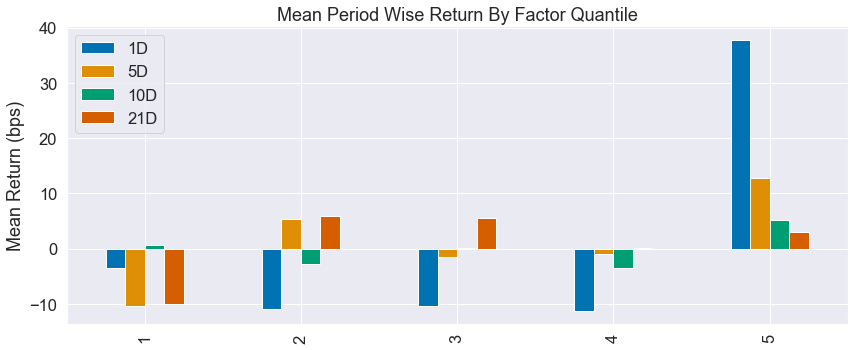

In [13]:
create_summary_tear_sheet(lr_factor_data);

## Ridge Regression

In [14]:
best_ridge_alpha = get_best_alpha(ridge_scores)
ridge_predictions = ridge_predictions[ridge_predictions.alpha==best_ridge_alpha].drop('alpha', axis=1)

In [15]:
ridge_factor = get_factor(ridge_predictions.predicted.swaplevel())
ridge_factor.head()

date                       Ticker
2020-02-21 00:00:00+00:00  BE        0.010817
                           BWEN      0.009673
                           CSIQ      0.005407
                           DOGEF     0.005089
                           ENPH      0.013925
dtype: float64

In [16]:
ridge_factor_data = get_clean_factor_and_forward_returns(factor = ridge_factor,
                                                         prices = trade_prices,
                                                         quantiles = 5,
                                                         periods = (1, 5, 10, 21))
ridge_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200 entries, (Timestamp('2020-02-21 00:00:00+0000', tz='UTC'), 'BE') to (Timestamp('2020-12-03 00:00:00+0000', tz='UTC'), 'VWSYF')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               2200 non-null   float64
 1   5D               2200 non-null   float64
 2   10D              2200 non-null   float64
 3   21D              2200 non-null   float64
 4   factor           2200 non-null   float64
 5   factor_quantile  2200 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 111.3+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.091504,0.021629,-0.011673,0.016139,600,27.272727
2,-0.062422,0.024935,-0.006665,0.013915,400,18.181818
3,-0.053989,0.031759,-0.003976,0.013608,400,18.181818
4,-0.048288,0.035303,-0.001228,0.013519,400,18.181818
5,-0.040731,0.038578,0.003333,0.012884,400,18.181818


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.621,0.303,0.092,0.227
beta,-0.053,-0.003,-0.115,-0.094
Mean Period Wise Return Top Quantile (bps),26.716,13.283,9.526,0.562
Mean Period Wise Return Bottom Quantile (bps),-12.768,-15.466,-0.019,-8.548
Mean Period Wise Spread (bps),39.484,28.022,8.615,8.289


Information Analysis


,1D,5D,10D,21D
IC Mean,0.025,0.050,0.018,0.041
IC Std.,0.367,0.344,0.330,0.332
Risk-Adjusted IC,0.067,0.147,0.054,0.125
t-stat(IC),0.947,2.073,0.763,1.763
p-value(IC),0.345,0.039,0.446,0.079
IC Skew,0.129,-0.012,0.322,0.051
IC Kurtosis,-0.694,-0.532,-0.226,-0.001


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.213,0.470,0.565,0.741
Quantile 2 Mean Turnover,0.490,0.721,0.761,0.804
Quantile 3 Mean Turnover,0.490,0.746,0.768,0.844
Quantile 4 Mean Turnover,0.470,0.721,0.782,0.827
Quantile 5 Mean Turnover,0.249,0.505,0.611,0.793


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.848,0.495,0.365,0.069


<Figure size 432x288 with 0 Axes>

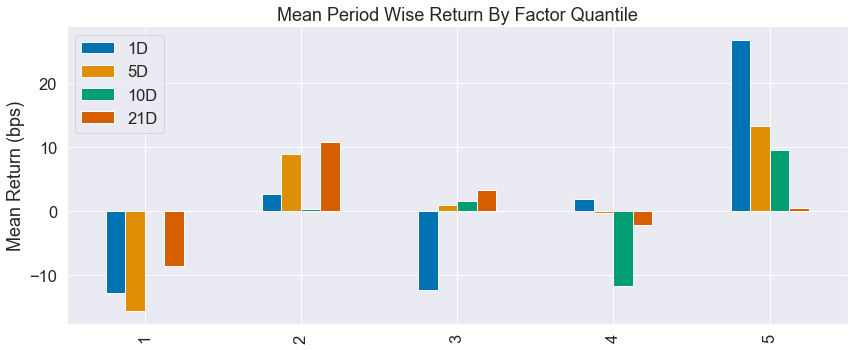

In [17]:
create_summary_tear_sheet(ridge_factor_data);

## Lasso Regression

In [18]:
best_lasso_alpha = get_best_alpha(lasso_scores)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha].drop('alpha', axis=1)

In [19]:
lasso_factor = get_factor(lasso_predictions.predicted.swaplevel())
lasso_factor.head()

date                       Ticker
2020-02-21 00:00:00+00:00  BE        0.006536
                           BWEN      0.007418
                           CSIQ      0.005987
                           DOGEF     0.005882
                           ENPH      0.009614
dtype: float64

In [20]:
lasso_factor_data = get_clean_factor_and_forward_returns(factor = lasso_factor,
                                                      prices = trade_prices,
                                                      quantiles = 5,
                                                      periods = (1, 5, 10, 21))
lasso_factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2200 entries, (Timestamp('2020-02-21 00:00:00+0000', tz='UTC'), 'BE') to (Timestamp('2020-12-03 00:00:00+0000', tz='UTC'), 'VWSYF')
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   1D               2200 non-null   float64
 1   5D               2200 non-null   float64
 2   10D              2200 non-null   float64
 3   21D              2200 non-null   float64
 4   factor           2200 non-null   float64
 5   factor_quantile  2200 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 111.3+ KB


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.049891,0.028309,-0.008071,0.012010,600,27.272727
2,-0.039511,0.029891,-0.004448,0.011257,400,18.181818
3,-0.038140,0.037482,-0.002563,0.011163,400,18.181818
4,-0.037956,0.043740,-0.000592,0.011497,400,18.181818
5,-0.034993,0.048733,0.003090,0.011147,400,18.181818


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.720,0.323,0.175,0.274
beta,-0.108,-0.021,-0.124,-0.075
Mean Period Wise Return Top Quantile (bps),32.085,15.736,4.261,-1.402
Mean Period Wise Return Bottom Quantile (bps),-7.618,-11.384,-3.842,-8.934
Mean Period Wise Spread (bps),39.703,26.365,6.789,6.441


Information Analysis


,1D,5D,10D,21D
IC Mean,0.034,0.049,0.030,0.067
IC Std.,0.378,0.337,0.310,0.284
Risk-Adjusted IC,0.090,0.146,0.098,0.237
t-stat(IC),1.266,2.065,1.389,3.350
p-value(IC),0.207,0.040,0.166,0.001
IC Skew,0.034,-0.182,0.277,-0.029
IC Kurtosis,-0.778,-0.566,-0.370,-0.013


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.191,0.453,0.570,0.711
Quantile 2 Mean Turnover,0.487,0.741,0.813,0.796
Quantile 3 Mean Turnover,0.480,0.708,0.721,0.821
Quantile 4 Mean Turnover,0.435,0.669,0.779,0.863
Quantile 5 Mean Turnover,0.219,0.469,0.603,0.849


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.863,0.514,0.331,0.014


<Figure size 432x288 with 0 Axes>

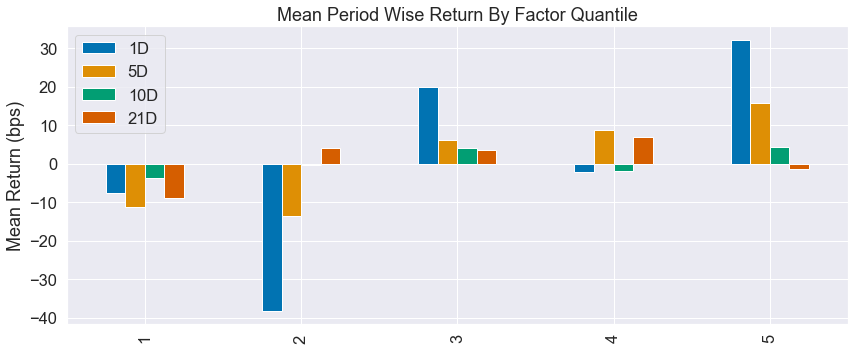

In [21]:
create_summary_tear_sheet(lasso_factor_data);